In [1]:
import os
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
variable_path_base = r'../data/variables'
variable_files_pattern = 'var-mes-*-fill-median-10.csv' #'var-mes-*-fill-median-10.csv'
variable_file_output = 'var-mes-{etiqueta}-{tipo}-{estacion}-fill-median-10-sct.png' #'var-mes-{etiqueta}-fill-median-10_sct.png'

variable_graph_title = '{tipo}-{estacion}-{etiqueta}-fill-median-10'

estation_completitud_pathp = r'../data/variables_profiles/CUM70_{etiqueta}.csv'

std_rev_interval = [-3, -2, 0, 2, 3]
qua_rev_interval = [0, 2, 3]

In [3]:
variable_path_base = variable_path_base.split('/')
variable_files = glob.glob(os.path.join(*variable_path_base, variable_files_pattern))
print('Estaciones completas:', estation_completitud_pathp)
print('variables Mensuales:', len(variable_files), *variable_files, sep = '\n')


Estaciones completas: ../data/variables_profiles/CUM70_{etiqueta}.csv
variables Mensuales:
6
..\data\variables\var-mes-PTPM_CON-fill-median-10.csv
..\data\variables\var-mes-Q_MEDIA_D-fill-median-10.csv
..\data\variables\var-mes-Q_MN_D-fill-median-10.csv
..\data\variables\var-mes-Q_MX_D-fill-median-10.csv
..\data\variables\var-mes-TMN_CON-fill-median-10.csv
..\data\variables\var-mes-TMX_CON-fill-median-10.csv


In [4]:
dtypes = { 'CodigoEstacion':'string','Etiqueta':'category'}
dtypesEstacionesCompletas = { 'codigo':'string'}
usecolsEstacionesCompletas = ['codigo']

dateparse = lambda x: datetime.strptime(x, '%Y-%m')
start_time = time.time()

In [5]:
def exploreVariable(f):
    #f = variable_files[2]
    
    print(f'Archivo: h:{time.asctime()} {f}')
    
    print(f'Leyendo...')
    df = pd.read_csv(f, dtype = dtypes, parse_dates = ['Fecha'], date_parser = dateparse)
    print(f'**** r:{df.shape} h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')
    
    cols_explore = df.loc[0:1,'min':'max'].columns
    etiqueta = df.iat[0,1]
    print(f'Etiqueta leída: {etiqueta}')
    
    estation_completitud_path = estation_completitud_pathp.format(etiqueta = etiqueta)
    
    print(f'Leyendo completitud... h:{time.asctime()} {estation_completitud_path}')
    dfEstacionesCompletas = pd.read_csv(estation_completitud_path, dtype = dtypesEstacionesCompletas, usecols = usecolsEstacionesCompletas)
    dfEstacionesCompletas.drop_duplicates('codigo', inplace = True)
    print(f'**** r:{dfEstacionesCompletas.shape} h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')
    
    print(f'Filtrando las completas al 70%...')
    df = df.merge(dfEstacionesCompletas, left_on='CodigoEstacion', right_on='codigo', how = 'inner' )
    df.drop('codigo', axis = 'columns', inplace = True)
    print(f'**** r:{df.shape} h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')
    
    
    print(f'Identificando largest 5')
    top5 = df.groupby('CodigoEstacion')['mean'].sum().sort_values().nlargest(5).reset_index()['CodigoEstacion'].to_list()
    print(top5)
    print(f'**** h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')
    
    print(f'Graficando largest 5')
    viewGraphs(df, etiqueta, top5, cols_explore, 'largest')
    print(f'**** h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')
    
    print(f'Identificando smallest 5')
    top5 = df.groupby('CodigoEstacion')['mean'].sum().sort_values().nsmallest(5).reset_index()['CodigoEstacion'].to_list()
    print(top5)
    print(f'**** h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')
    
    print(f'Graficando smallest 5')
    viewGraphs(df, etiqueta, top5, cols_explore, 'smallest')
    print(f'**** h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')

In [6]:
def viewGraphs(df, etiqueta, estaciones, cols_explore, tipo):
    for estacion in estaciones:
        print(f'Graficando estación: {estacion}...')
        dfe = df[(df['CodigoEstacion'] == estacion)]
        print(f'**** r:{dfe.shape} h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')

        title = variable_graph_title.format(tipo = tipo, estacion = estacion, etiqueta = etiqueta)
        
        fig = plt.figure(figsize = (10,8))
        fig.suptitle(title, fontsize=16)

        for i, c in enumerate(cols_explore):    
            ax = fig.add_subplot(220 + i + 1)
            g = sns.scatterplot(x = 'Fecha', y = c, data = dfe, ax = ax)
            #g = sns.boxplot(dfe[c], ax = ax)

            #continue

            xini = dfe['Fecha'].min()
            xfin = dfe['Fecha'].max()

            std = dfe[c].std()
            mean = dfe[c].median()

            Q1, Q3 = dfe[c].quantile([0.25, 0.75])
            IQR = Q3 - Q1

            for i in std_rev_interval:
                ax.hlines(y = (mean + (i * std)), xmin = xini, xmax = xfin, colors=('red' if i != 0 else 'yellow'))
                ax.text(y = (mean + (i * std)), x = xfin, s = 'sd'+str(i), size = 9, color = 'red')


            for i in qua_rev_interval:
                ax.hlines(y = (Q3 + (i * IQR)), xmin = xini, xmax = xfin, colors = ('blue' if i != 0 else 'green'))
                ax.text(y = (Q3 + (i * IQR)), x = xfin, s = 'qs'+str(i), size = 9, color = 'blue')

                ax.hlines(y = (Q1 + (-1 * i * IQR)), xmin = xini, xmax = xfin, colors = ('blue' if i != 0 else 'green'))
                ax.text(y = (Q1 + (-1 * i * IQR)), x = xfin, s = 'qi'+str(-1 * i), size = 9, color = 'blue')

            #ax.plot()
            print(f'**** h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')

            p = variable_file_output.format(etiqueta = etiqueta, estacion = estacion, tipo = tipo)
            print(f'Grabando...', p)
            
            p = os.path.join(*variable_path_base, 'images', p)
            plt.savefig(p)
            print(f'**** h:{time.asctime()} t:{(time.time() - start_time) / 60} ****')

Archivo: h:Sat Jun 20 14:09:52 2020 ..\data\variables\var-mes-PTPM_CON-fill-median-10.csv
Leyendo...
**** r:(523377, 7) h:Sat Jun 20 14:10:02 2020 t:0.17169994513193768 ****
Etiqueta leída: PTPM_CON
Leyendo completitud... h:Sat Jun 20 14:10:02 2020 ../data/variables_profiles/CUM70_PTPM_CON.csv
**** r:(594, 1) h:Sat Jun 20 14:10:02 2020 t:0.17189999024073283 ****
Filtrando las completas al 70%...
**** r:(209682, 7) h:Sat Jun 20 14:10:02 2020 t:0.17438330252965292 ****
Identificando largest 5
['53080020', '11040010', '11010010', '51020010', '54020080']
**** h:Sat Jun 20 14:10:02 2020 t:0.17501663366953532 ****
Graficando largest 5
Graficando estación: 53080020...
**** r:(353, 7) h:Sat Jun 20 14:10:02 2020 t:0.17546675205230713 ****
**** h:Sat Jun 20 14:10:03 2020 t:0.17688329617182413 ****
Grabando... var-mes-PTPM_CON-largest-53080020-fill-median-10-sct.png
**** h:Sat Jun 20 14:10:03 2020 t:0.1792672077814738 ****
**** h:Sat Jun 20 14:10:03 2020 t:0.1803000529607137 ****
Grabando... var-

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':



Grabando... var-mes-Q_MN_D-largest-25027530-fill-median-10-sct.png
**** h:Sat Jun 20 14:10:48 2020 t:0.9262999375661214 ****
**** h:Sat Jun 20 14:10:48 2020 t:0.9276666641235352 ****
Grabando... var-mes-Q_MN_D-largest-25027530-fill-median-10-sct.png
**** h:Sat Jun 20 14:10:48 2020 t:0.9320333242416382 ****
**** h:Sat Jun 20 14:10:48 2020 t:0.9330000162124634 ****
Grabando... var-mes-Q_MN_D-largest-25027530-fill-median-10-sct.png
**** h:Sat Jun 20 14:10:48 2020 t:0.9378666361172994 ****
**** h:Sat Jun 20 14:10:48 2020 t:0.9395833055178324 ****
Grabando... var-mes-Q_MN_D-largest-25027530-fill-median-10-sct.png
**** h:Sat Jun 20 14:10:49 2020 t:0.9493999282519022 ****
Graficando estación: 25027020...
**** r:(353, 7) h:Sat Jun 20 14:10:49 2020 t:0.9494666695594788 ****
**** h:Sat Jun 20 14:10:49 2020 t:0.9505666772524516 ****
Grabando... var-mes-Q_MN_D-largest-25027020-fill-median-10-sct.png
**** h:Sat Jun 20 14:10:49 2020 t:0.9535166660944621 ****
**** h:Sat Jun 20 14:10:49 2020 t:0.9548

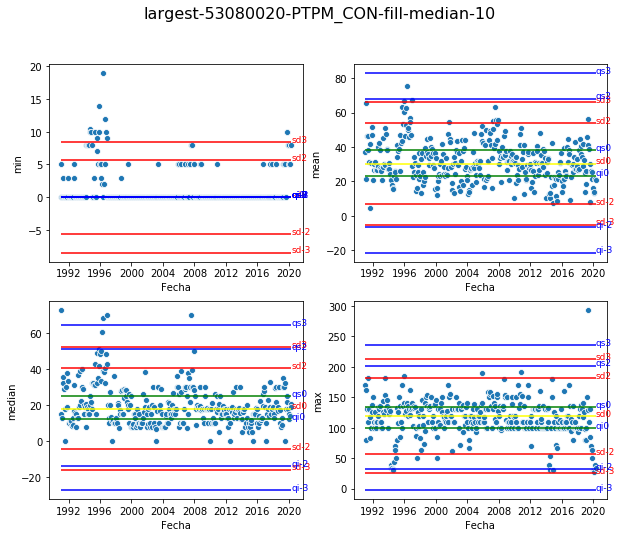

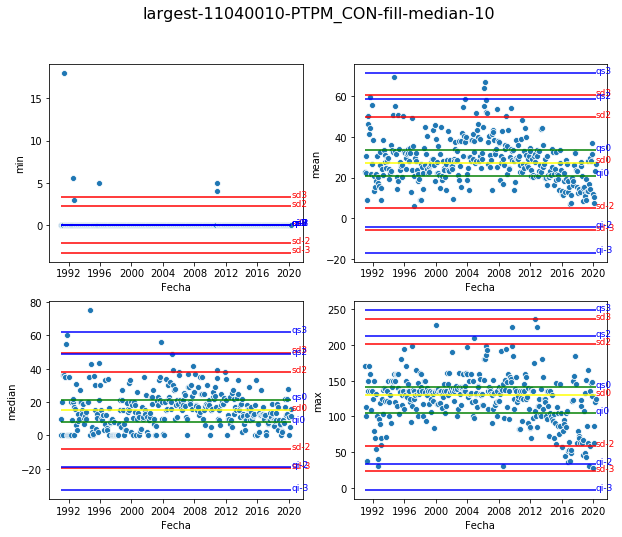

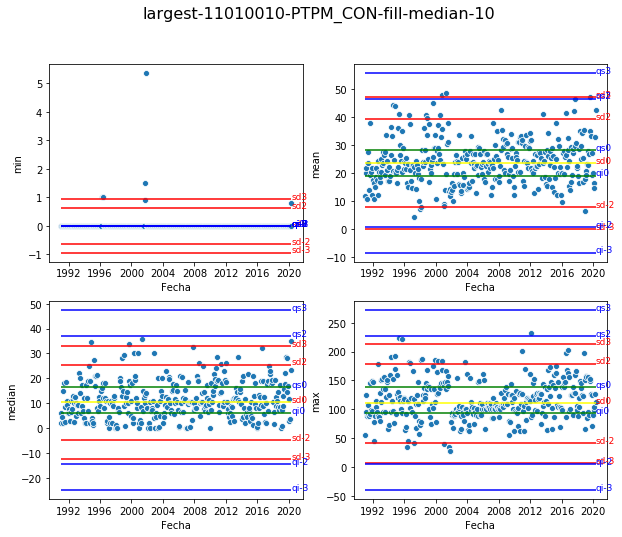

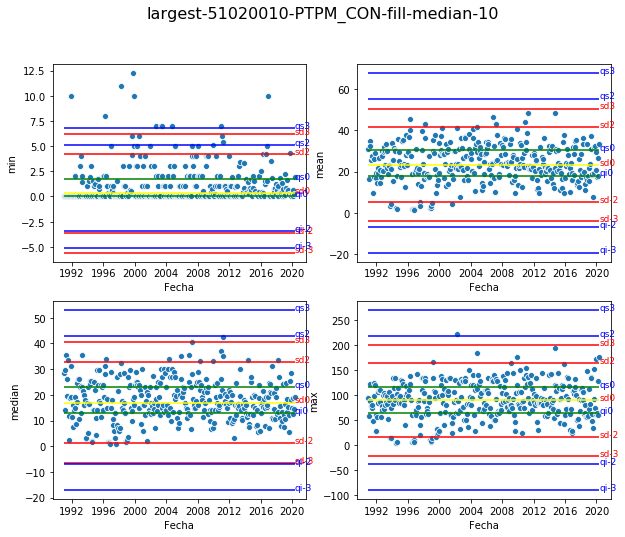

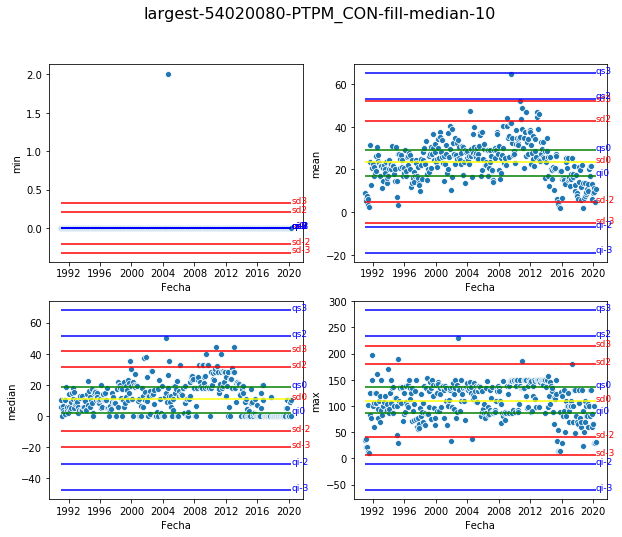

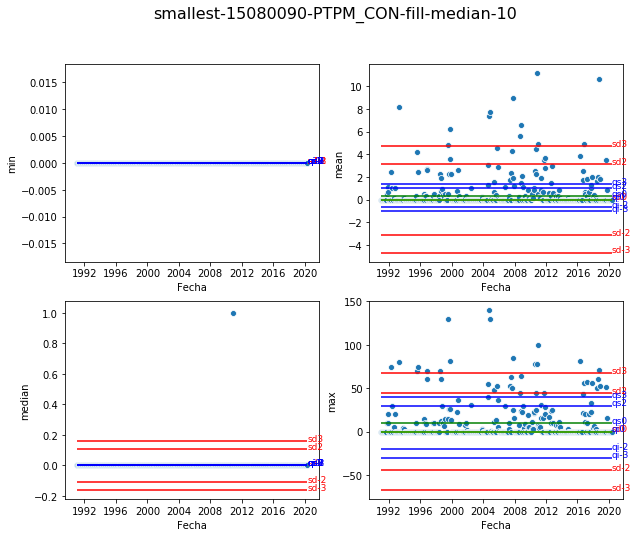

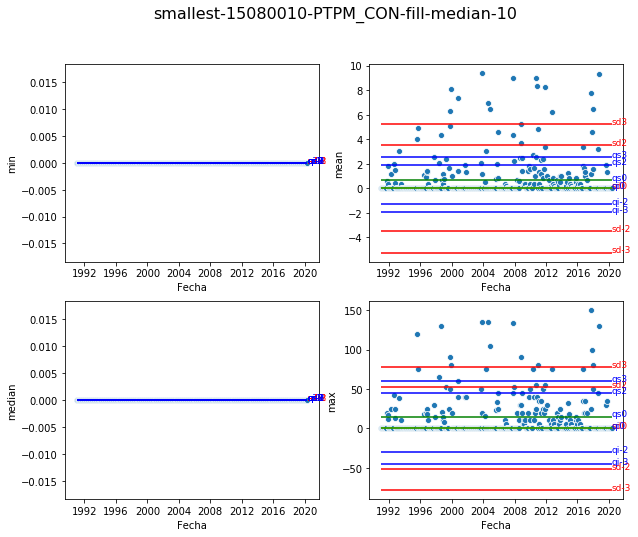

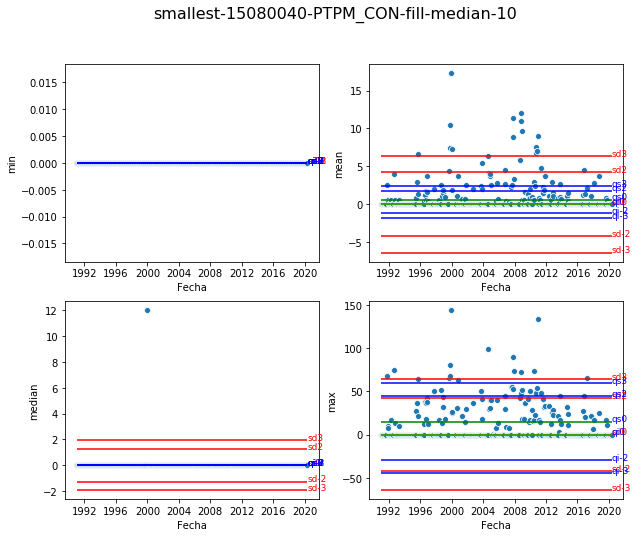

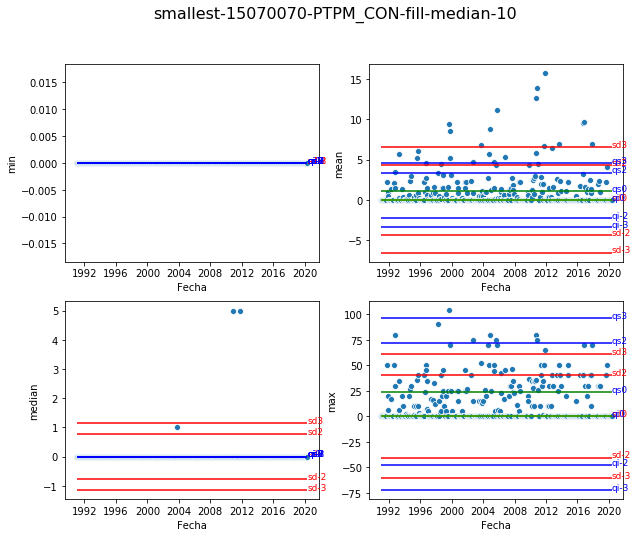

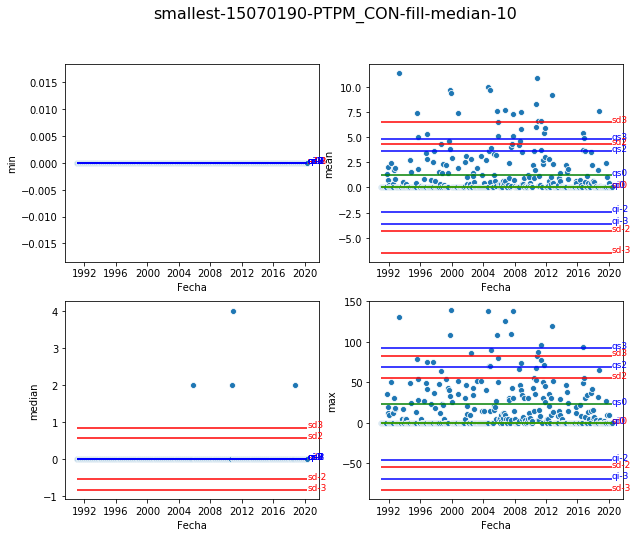

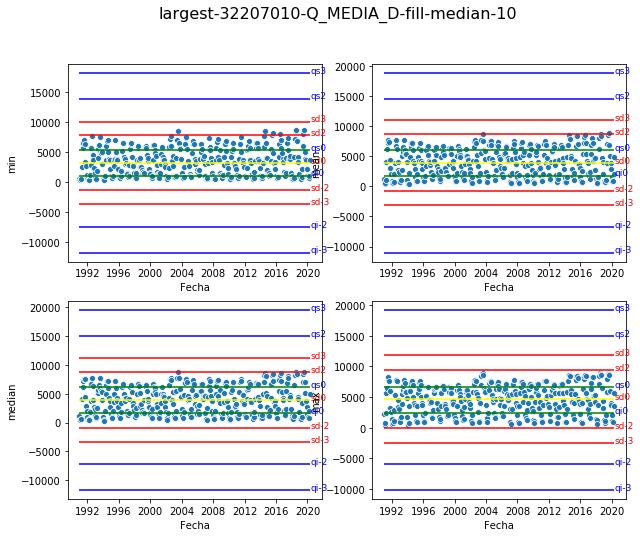

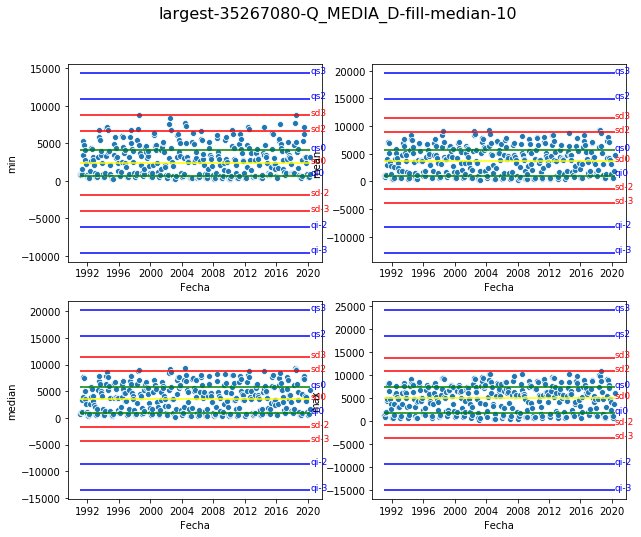

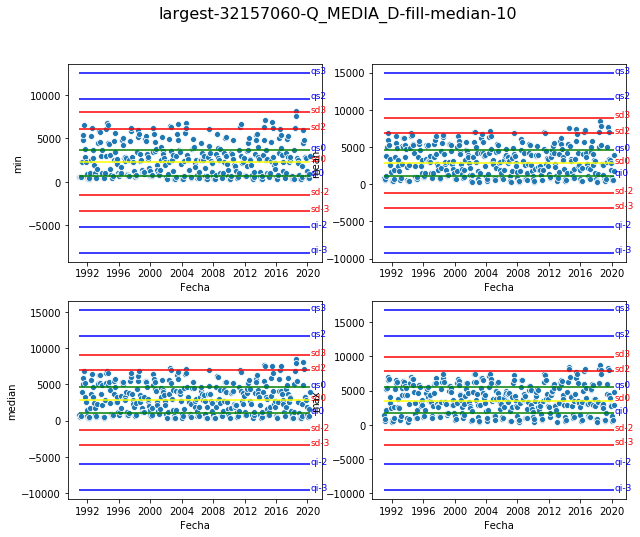

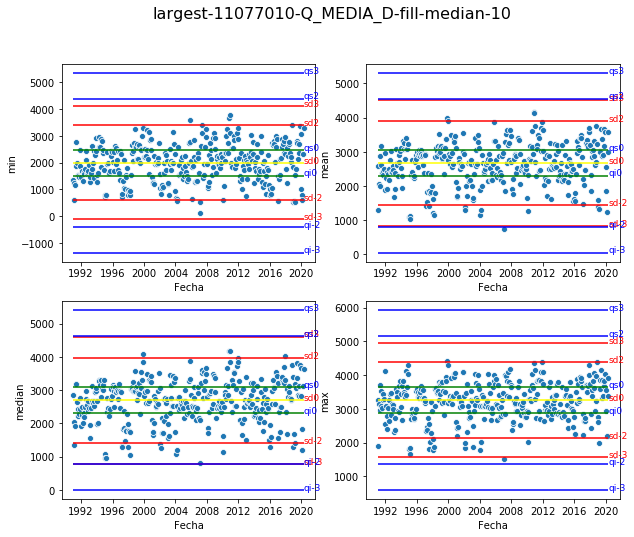

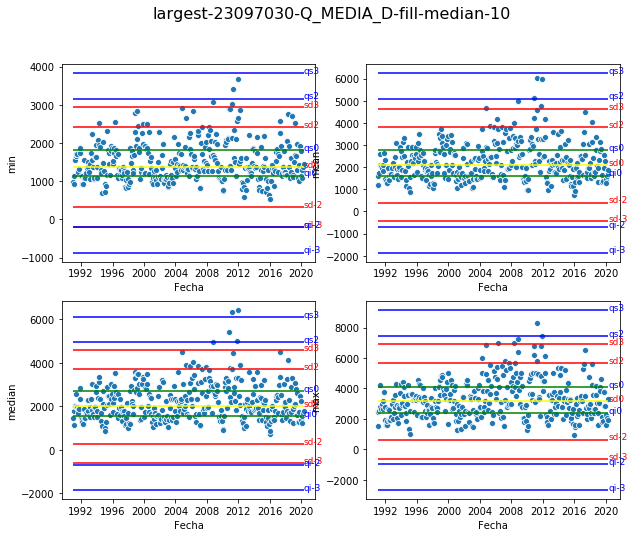

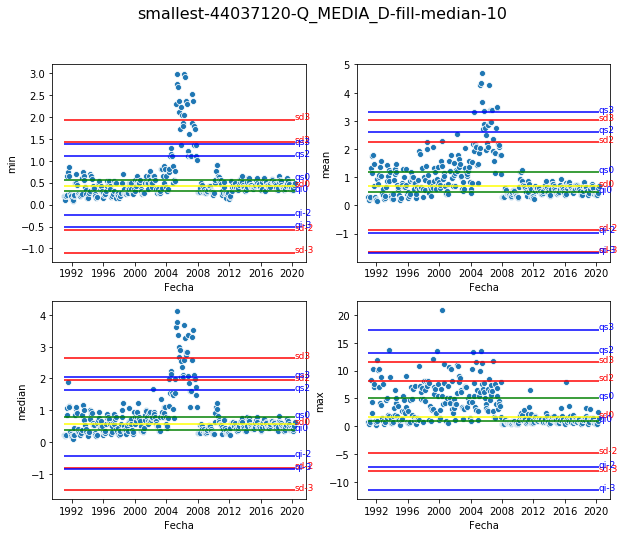

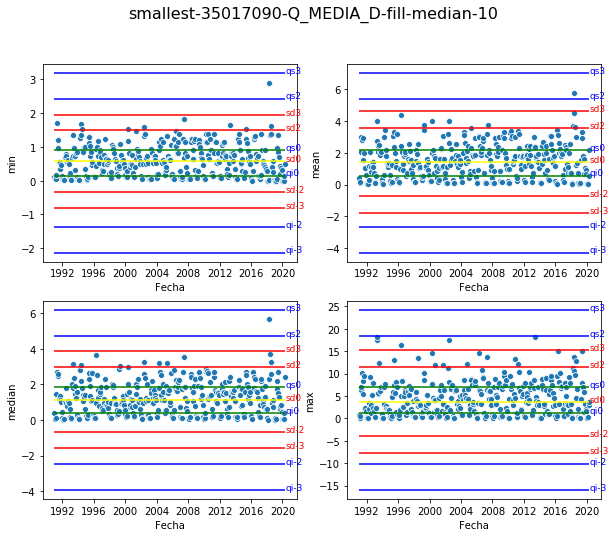

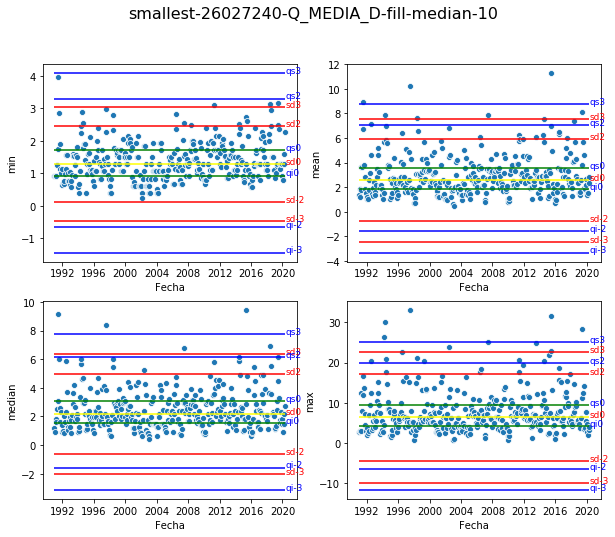

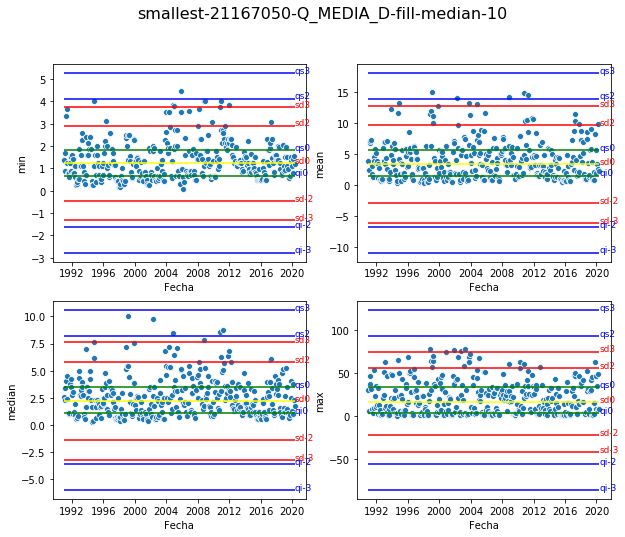

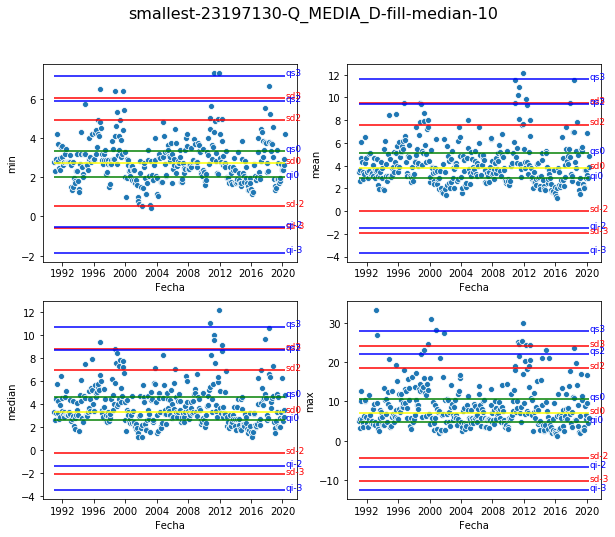

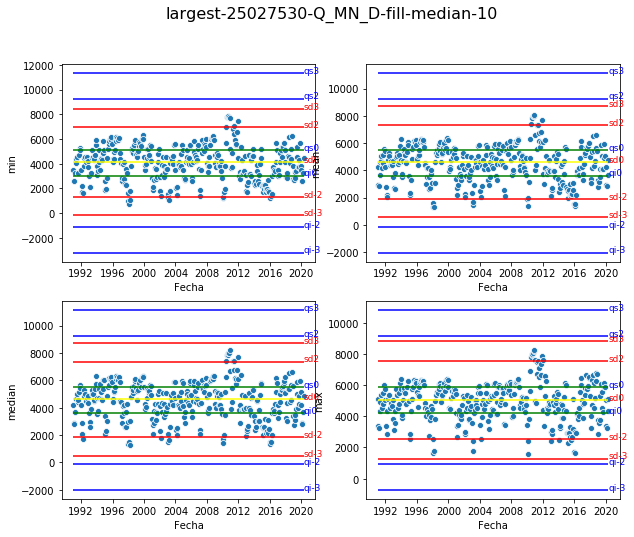

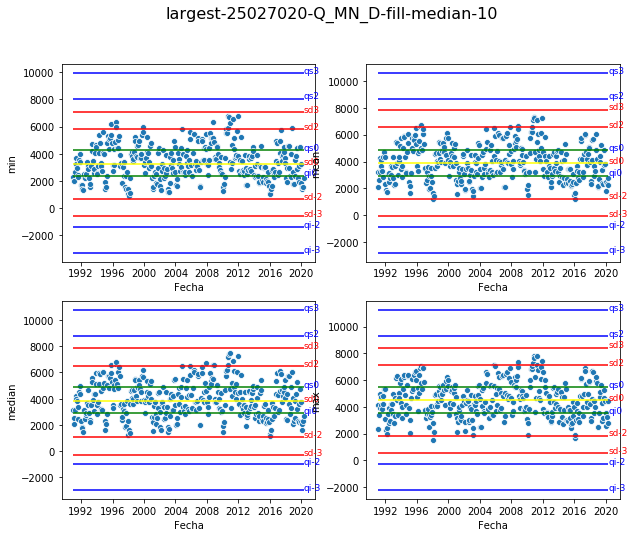

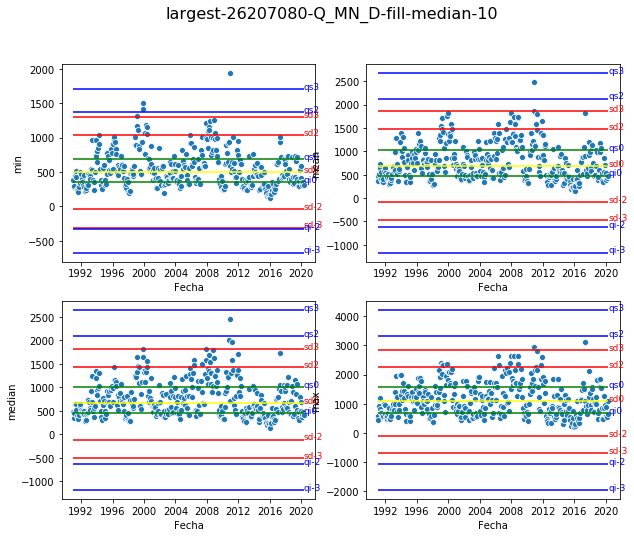

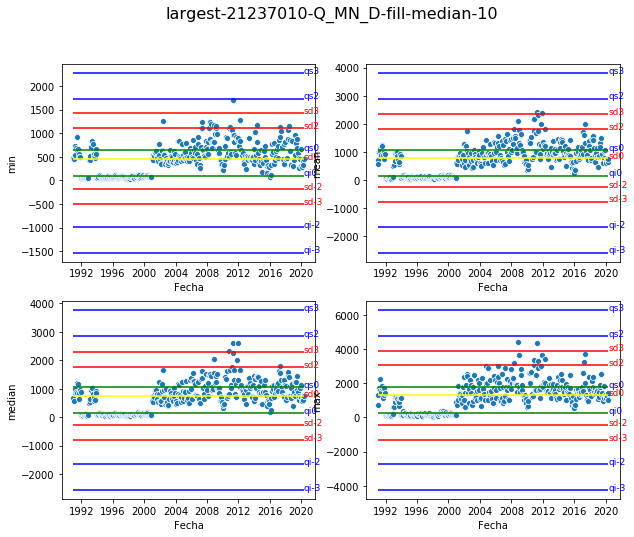

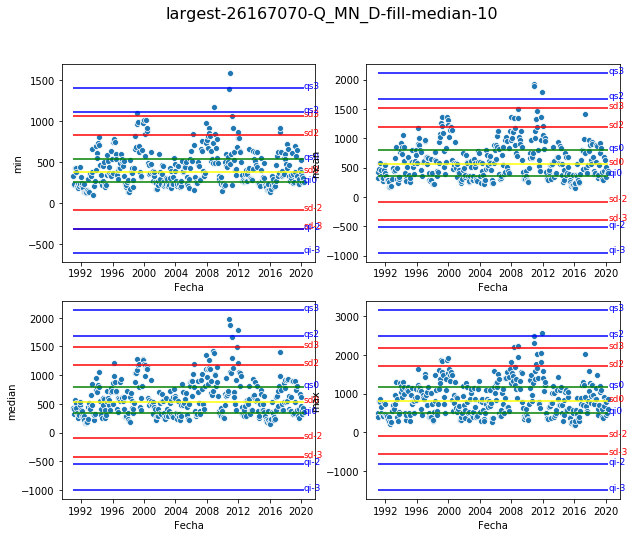

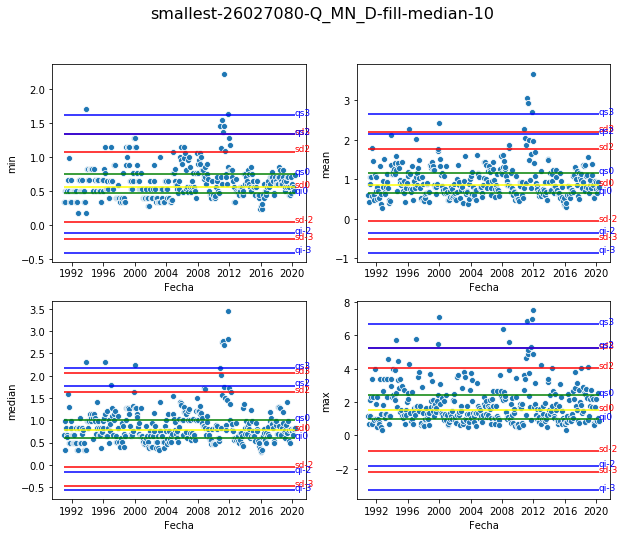

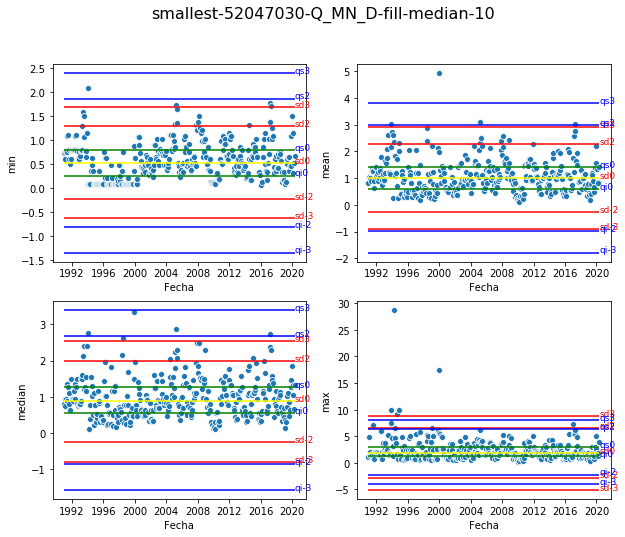

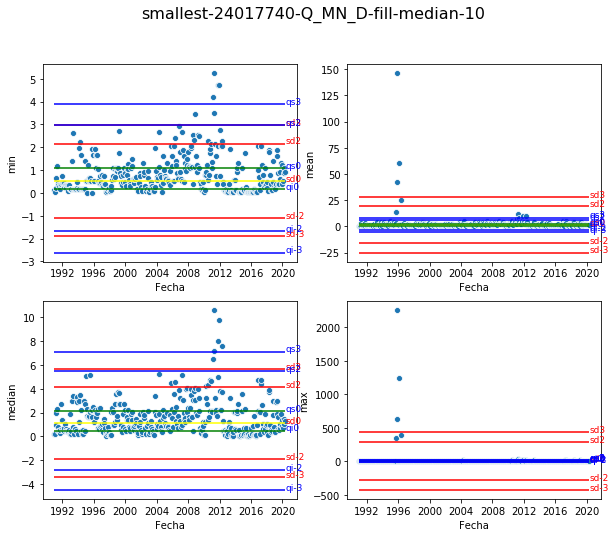

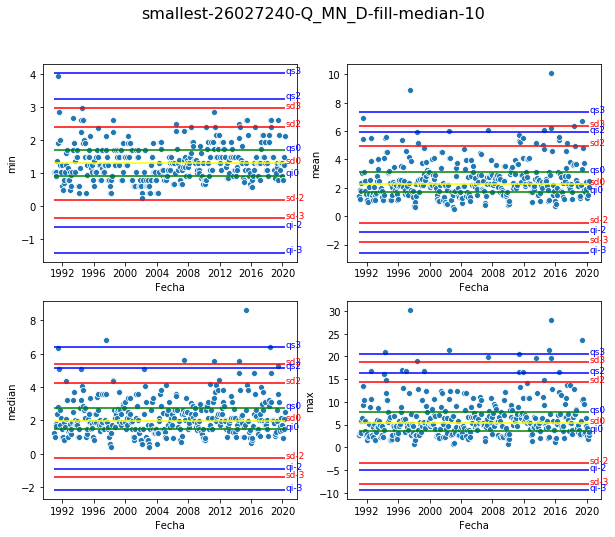

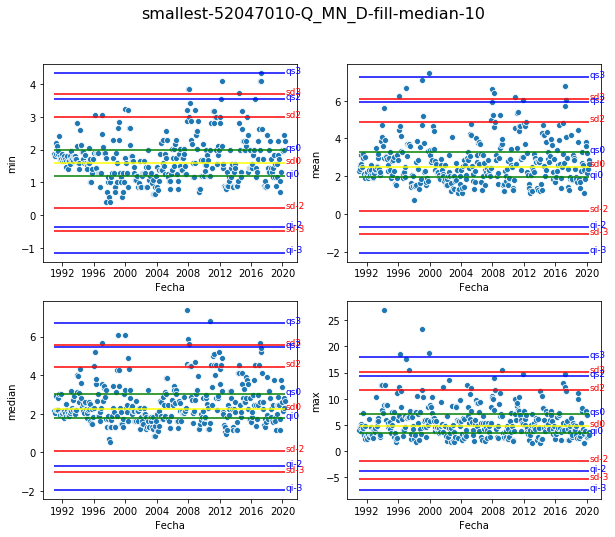

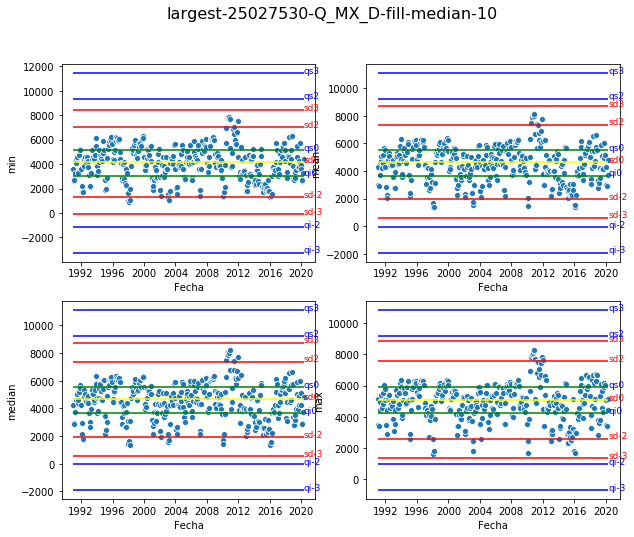

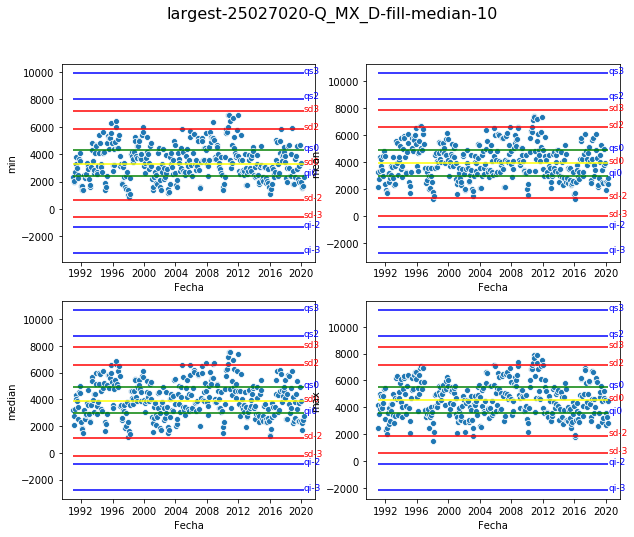

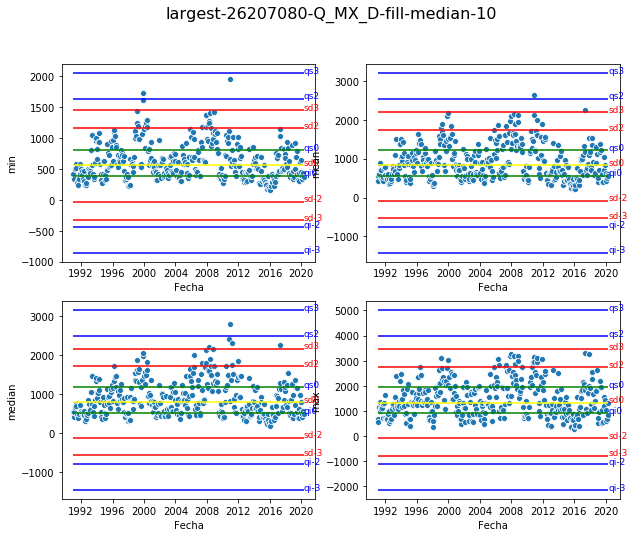

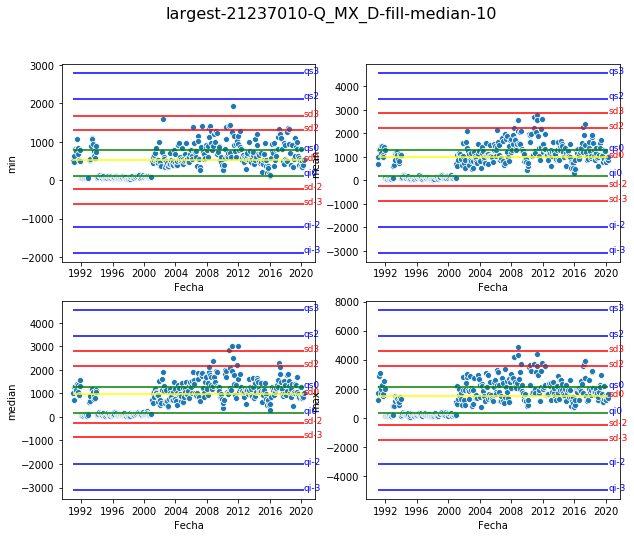

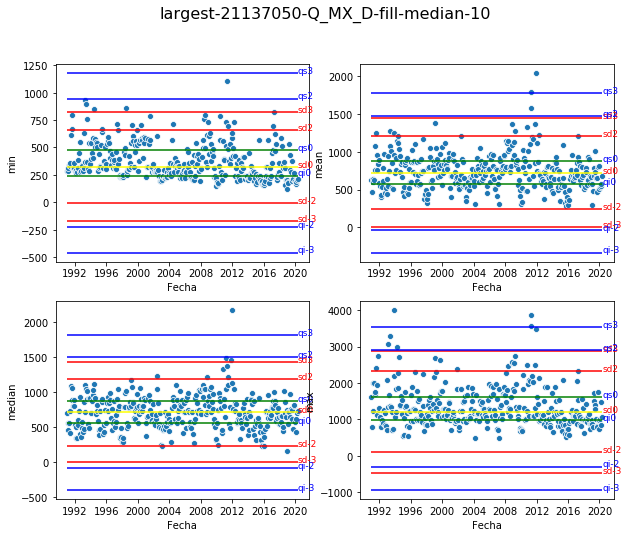

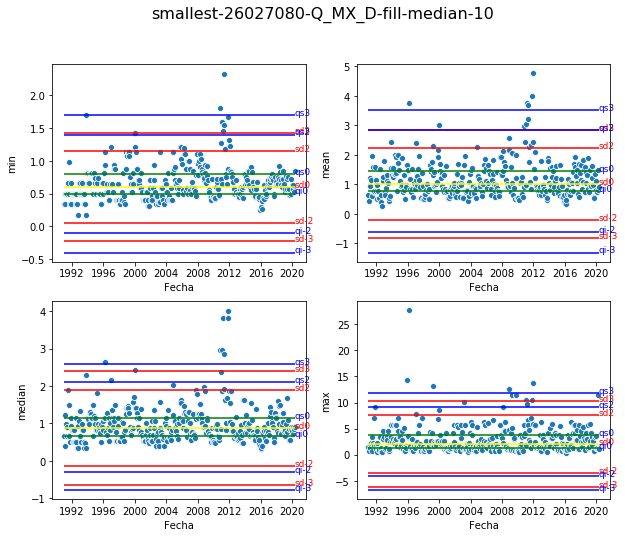

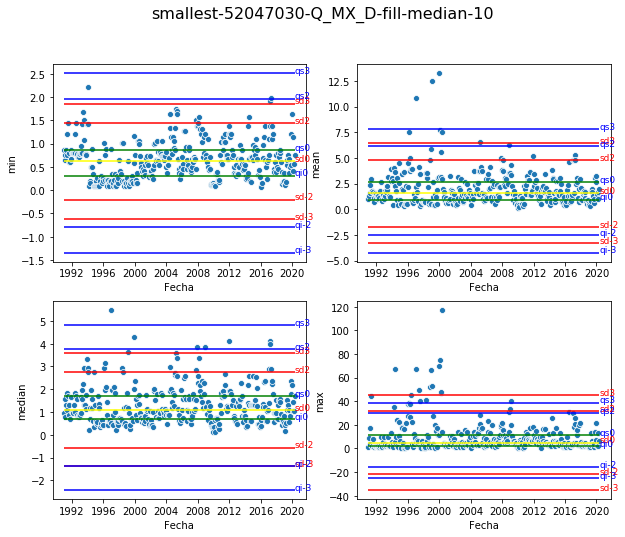

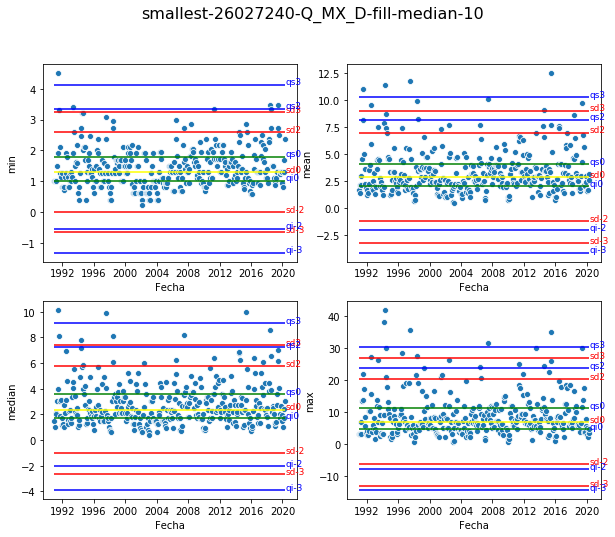

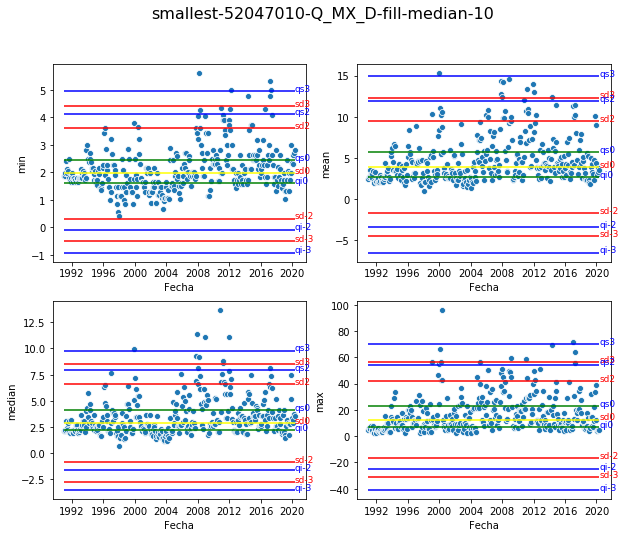

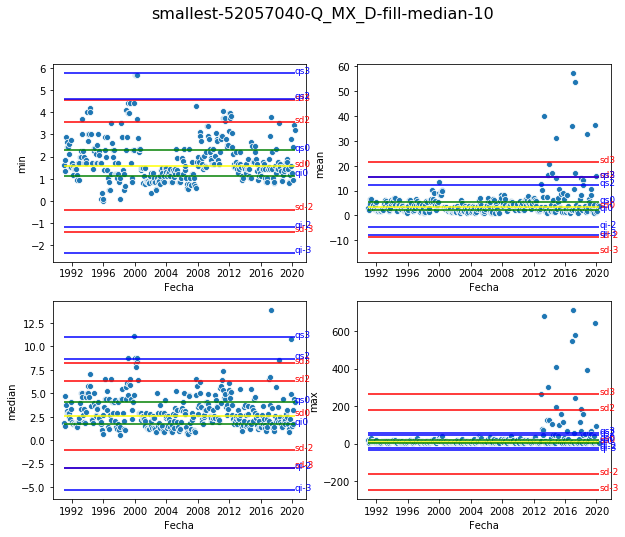

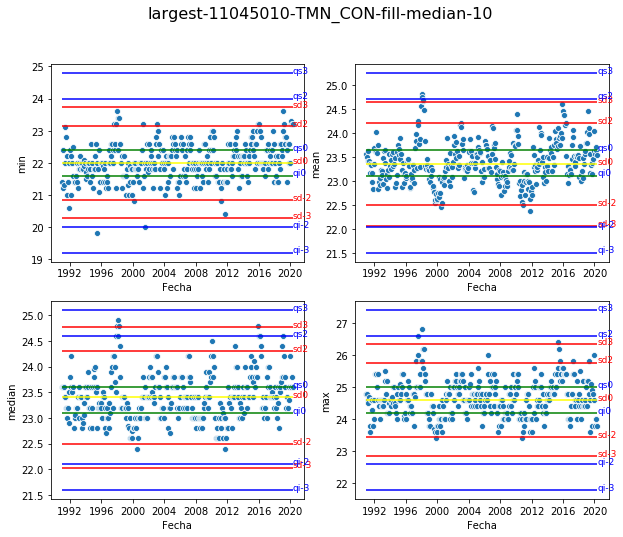

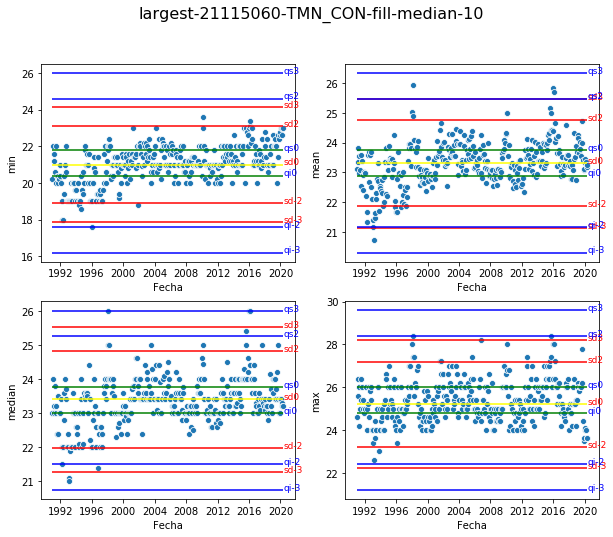

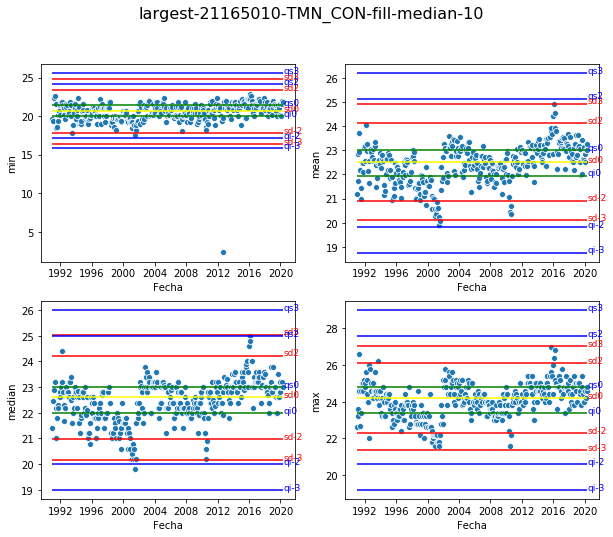

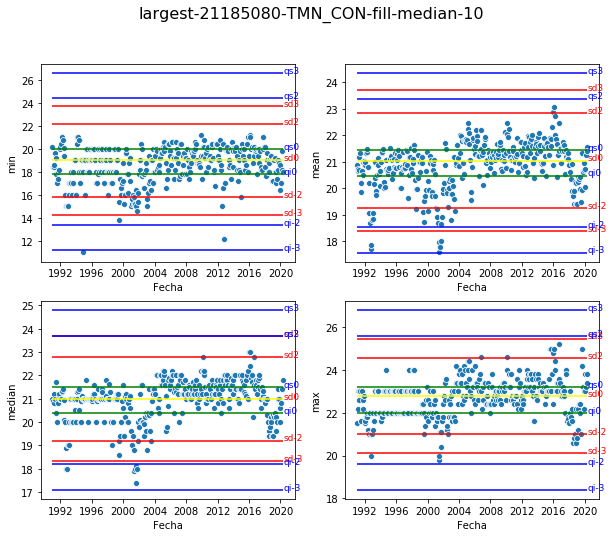

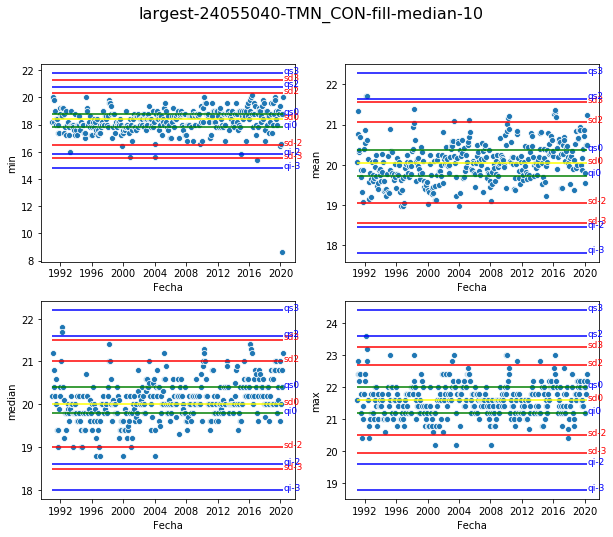

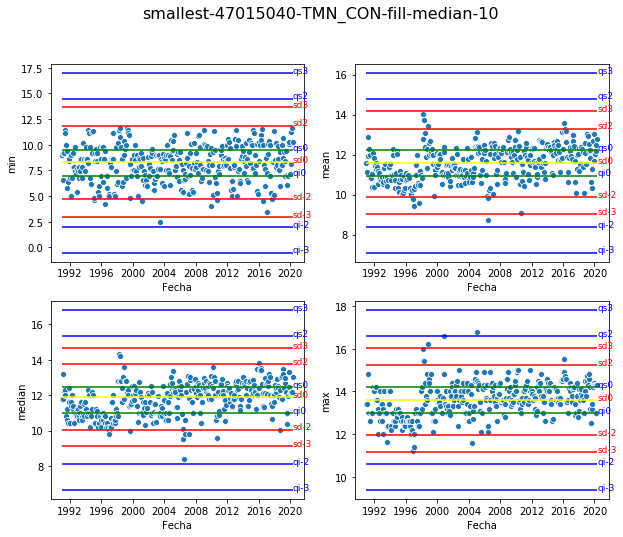

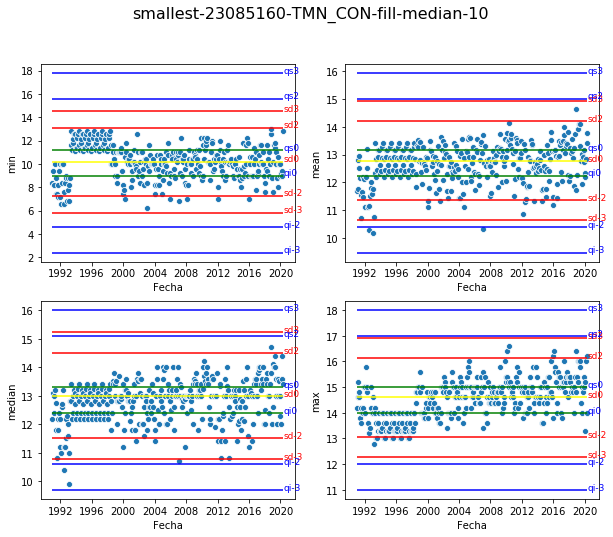

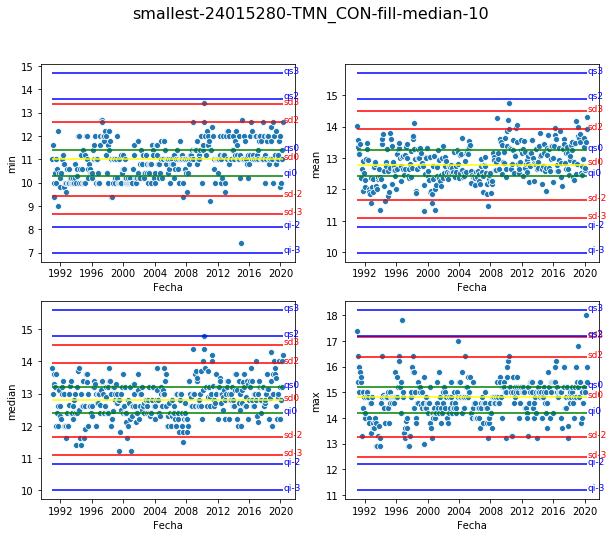

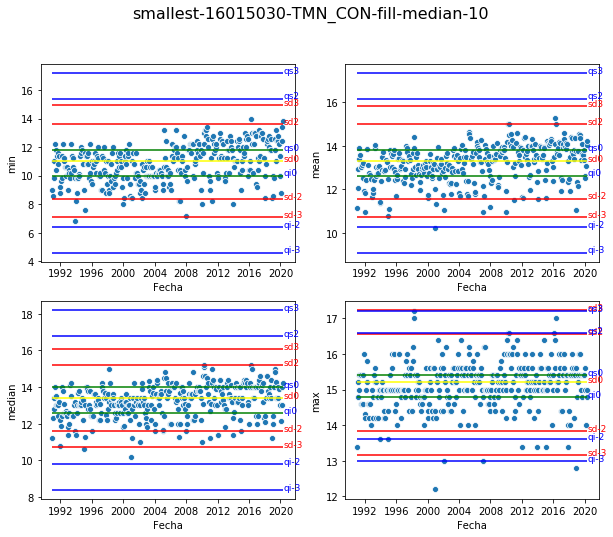

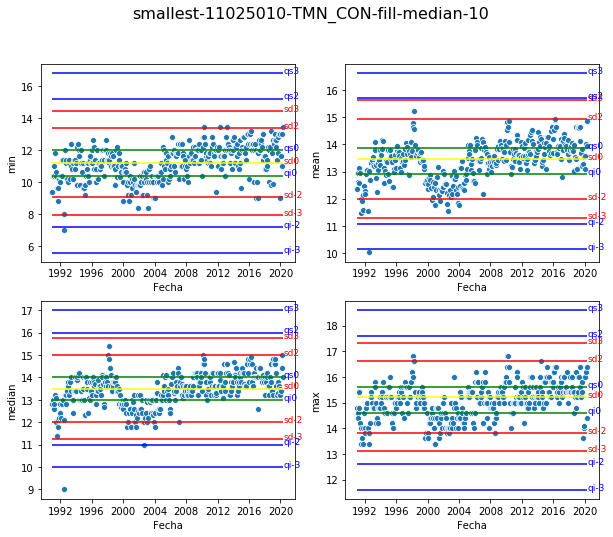

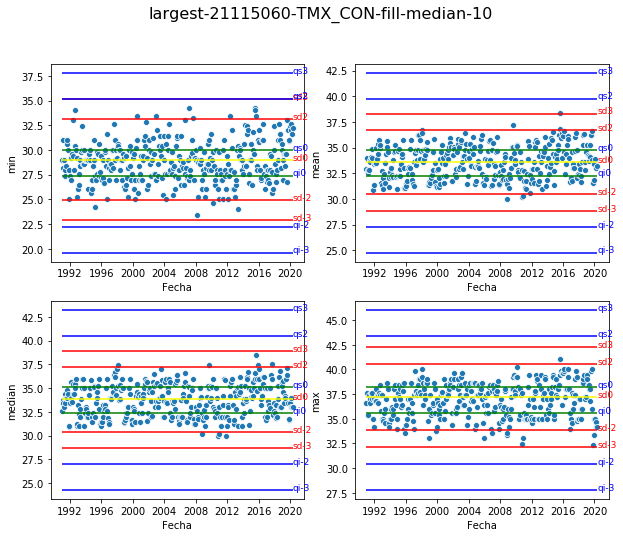

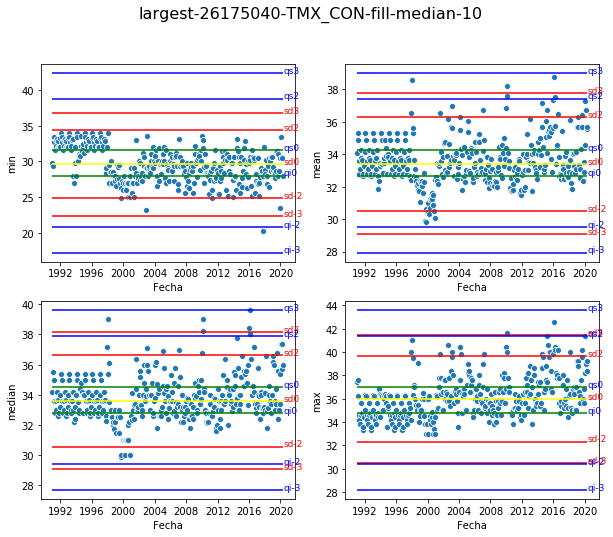

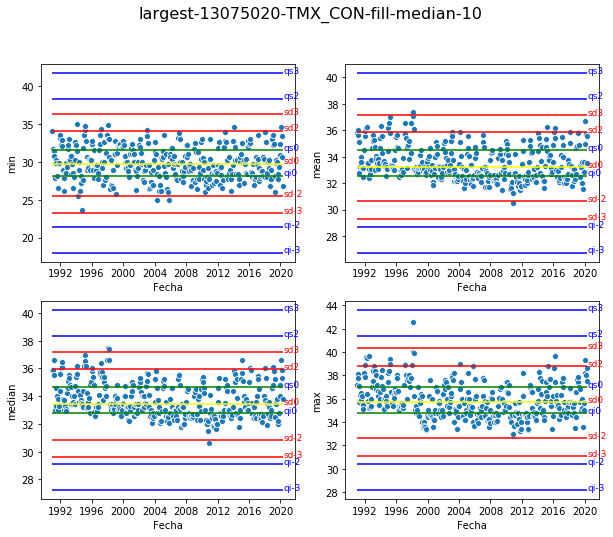

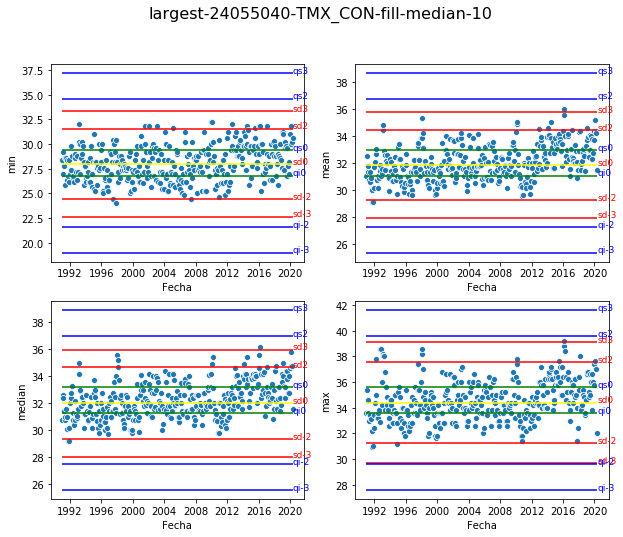

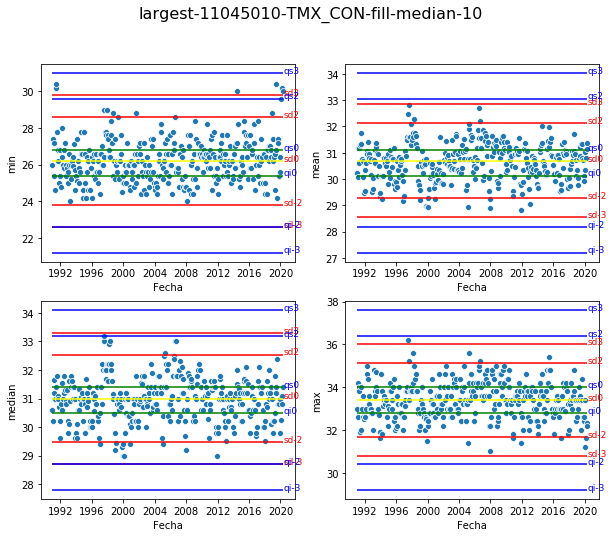

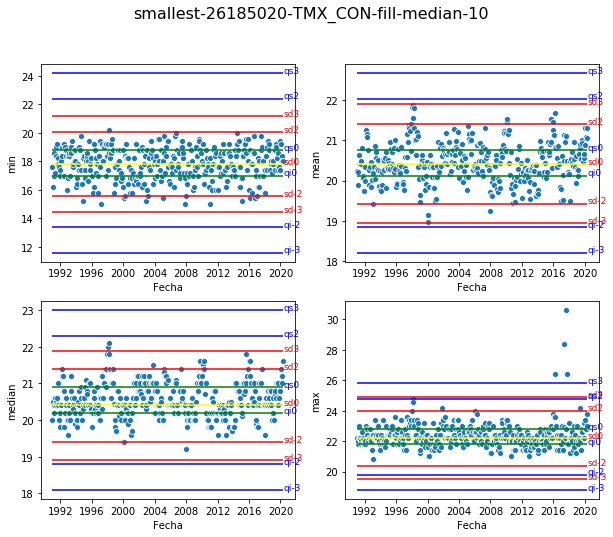

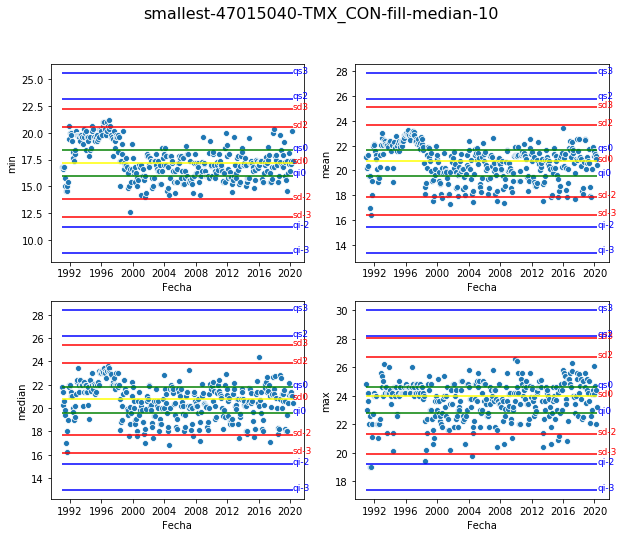

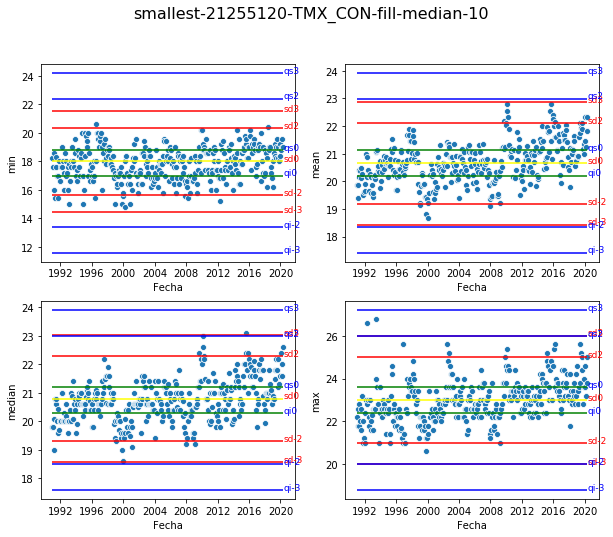

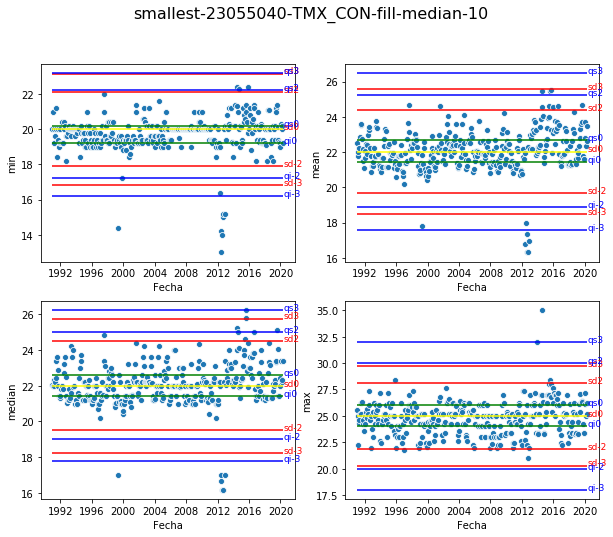

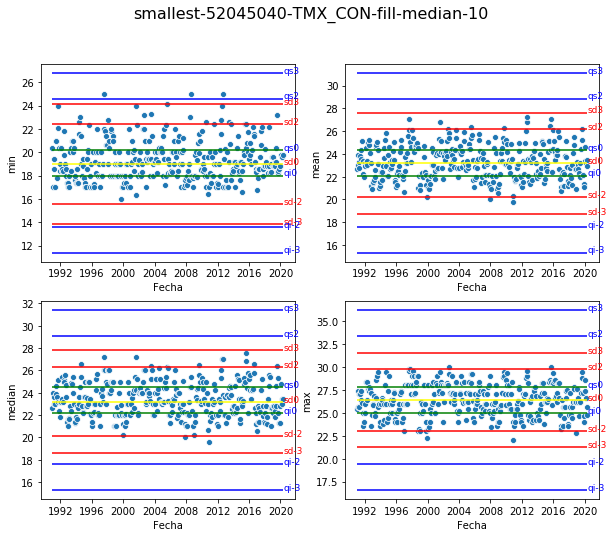

In [7]:
%%time
for f in variable_files:
    exploreVariable(f)